In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb

from mykaggle.metric.mse import rmsle
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.lib.pandas_util import change_column_name
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
settings = yaml.safe_load('''
name: '188_eda'
competition: atmacup8
seed: 1019
training:
    num_folds: 5
    num_rounds: 1000
    early_stopping_rounds: 100
    verbose_eval: 20
lgbm_params:
    objective: binary
    learning_rate: 0.05
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])
pd.set_option('display.max_rows', 500)

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [5]:
df_train = pd.read_csv(datadir / 'id_train.csv')
df_test = pd.read_csv(datadir / 'id_test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 17), (8360, 12))

In [6]:
df_train.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


In [7]:
df_test.head().T

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4
Name,Hitman 2: Silent Assassin,Legacy of Kain: Soul Reaver,Metal Gear Solid 2: Substance,Silent Hill: Homecoming,Silent Hill: Homecoming
Platform,XB,PS,XB,X360,PS3
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Eidos Interactive,Eidos Interactive,Konami Digital Entertainment,Konami Digital Entertainment,Konami Digital Entertainment
Critic_Score,84,91,87,70,71
Critic_Count,23,17,28,54,41
User_Score,8,9,8.5,6.9,6.9
User_Count,19,132,39,180,143
Developer,Io Interactive,Crystal Dynamics,KCEJ,Double Helix Games,Double Helix Games


In [8]:
df_submission.head()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Global_Sales
0,63.371815
1,63.371815
2,63.371815
3,63.371815
4,63.371815


In [9]:
df_train.loc[:, 'has_na_sales'] = df_train.loc[:, 'NA_Sales']  > 0
df_train.loc[:, 'has_eu_sales'] = df_train.loc[:, 'EU_Sales']  > 0
df_train.loc[:, 'has_jp_sales'] = df_train.loc[:, 'JP_Sales']  > 0
df_train.loc[:, 'has_other_sales'] = df_train.loc[:, 'Other_Sales']  > 0
# df_train.to_csv(datadir / 'country_train.csv', index=False)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# 要検討
df_best_pred = pd.read_csv('../ckpt/187_name_count/187_name_count.csv')
df_test.loc[:, 'Global_Sales'] = df_best_pred.loc[:, 'Global_Sales']

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
train = df_train.copy()
test = df_test.copy()
train['is_test'] = False
test['is_test'] = True
df_whole = pd.concat([train, test])

In [12]:
train_others = {
    'main': df_train.copy(),
    'another': df_test.copy()
}
test_others = {
    'main': df_test.copy(),
    'another': df_train.copy(),
}

# Publisher Platform King

In [ ]:
def platform_king(df: pd.DataFrame) -> pd.DataFrame:
    df_platform = df.groupby(['Platform', 'Publisher'])['Name'].count().reset_index()
    df_platform = change_column_name(df_platform, 'Name', 'count')
    df_pub_platform_target_mean = df.groupby(['Platform', 'Publisher'])['Global_Sales'].mean().reset_index()
    df_pub_platform_target_mean = change_column_name(df_pub_platform_target_mean, 'Global_Sales', 'mean_target')
    df_platform = pd.merge(df_platform, df_pub_platform_target_mean, how='left', on=['Platform', 'Publisher'])
    df_platform.loc[:, 'platform_score'] = df_platform.loc[:, 'count'] * df_platform.loc[:, 'mean_target']
    df_pub_platform_max = df_platform.groupby('Platform')['platform_score'].max().reset_index()
    df_pub_platform_max = change_column_name(df_pub_platform_max, 'platform_score', 'max_score')
    df_platform = pd.merge(df_platform, df_pub_platform_max, how='left', on='Platform')
    df_platform['rank'] = df_platform.groupby(['Platform'])['platform_score'].rank(ascending=False)
    return df_platform

In [ ]:
df_platform_train = platform_king(df_train)
df_platform_whole = platform_king(df_whole)

In [ ]:
df_platform_train[df_platform_train.loc[:, 'rank'] <= 3.0]

In [ ]:
df_platform_whole = df_platform_whole[df_platform_whole.loc[:, 'rank'] <= 3.0]
df_platform_whole = df_platform_whole[df_platform_whole.loc[:, 'platform_score'] >= df_platform_whole.loc[:, 'max_score'] * 0.6]
df_platform_whole = df_platform_whole[df_platform_whole.loc[:, 'platform_score'] >= 10.0]
df_platform_whole['platform_king'] = 1 

In [ ]:
df_platform_whole

In [ ]:
df_pub_train = df_train.groupby('Publisher')['Name'].count().reset_index()
df_pub_test = df_test.groupby('Publisher')['Name'].count().reset_index()
df_pub_train_target = df_train.groupby('Publisher')['Global_Sales'].agg(['mean', 'median', 'sum']).reset_index()
df_pub_test_target = df_test.groupby('Publisher')['Global_Sales'].agg(['mean', 'median', 'sum']).reset_index()

In [ ]:
df_pub_train = pd.merge(df_pub_train, df_pub_train_target, how='left', on='Publisher')
df_pub_test = pd.merge(df_pub_test, df_pub_test_target, how='left', on='Publisher')

In [ ]:
df_pub_train.sort_values(by='Name', ascending=False).head(20)

In [ ]:
df_pub_test.sort_values(by='Name', ascending=False).head(20)

# Publisher Unknown

In [15]:
df_test.loc[df_test.loc[:, 'Publisher'] == 'Unknown', :]

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id,Global_Sales
5,Cubix Robots for Everyone: Clash 'n' Bash,GBA,NaN,Action,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,8364,5.408323
8,Nicktoons: Battle for Volcano Island,GC,NaN,Action,Unknown,NaN,NaN,7,4.0,Blue Tongue Entertainment,E,8367,5.430704
12,Twisted Metal: Small Brawl,PS,NaN,Action,Unknown,51.0,14.0,7.6,49.0,Incognito Inc.,T,8371,18.809165
13,Teen Titans,GBA,NaN,Action,Unknown,61.0,9.0,tbd,NaN,Artificial Mind and Movement,E10+,8372,9.472561
16,Jurassic Park: The Game,X360,NaN,Action,Unknown,60.0,9.0,3.6,138.0,Telltale Games,T,8375,18.779847
17,WCW Backstage Assault,N64,NaN,Action,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,8376,14.427532
24,Fullmetal Alchemist: Brotherhood,PSP,NaN,Action,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,8383,4.238883
25,Super Duper Sumos,GBA,NaN,Action,Unknown,57.0,5.0,tbd,NaN,Handheld Games,E,8384,6.827206
26,Dinotopia: The Sunstone Odyssey,GC,NaN,Action,Unknown,50.0,4.0,tbd,NaN,Vicious Cycle,T,8385,5.134557
27,Aquaman: Battle for Atlantis,XB,NaN,Action,Unknown,26.0,13.0,2.7,15.0,Lucky Chicken,T,8386,6.988725


In [22]:
df_train['Publisher'].nunique()

295

In [29]:
pub_count = df_train.groupby('Publisher')['Name'].count().reset_index()
pub_count = change_column_name(pub_count, 'Name', 'publisher_count')
df_train = pd.merge(df_train, pub_count, how='left', on='Publisher')
df_train

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,User_Score,User_Count,Developer,Rating,id,has_na_sales,has_eu_sales,has_jp_sales,has_other_sales,publisher_count
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,...,7.9,22.0,Traveller's Tales,E10+,0,True,True,False,True,235
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,...,6.6,28.0,Traveller's Tales,E10+,1,True,True,False,True,90
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,...,7.4,10.0,Traveller's Tales,E10+,2,True,True,False,True,235
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,...,NaN,NaN,NaN,NaN,3,True,True,False,True,367
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,...,7.8,13.0,Traveller's Tales,E10+,4,True,True,False,True,235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,0,4,0,0,4,...,8,569.0,Paradox Development Studio,NaN,8354,False,True,False,False,23
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,0,1,0,0,1,...,NaN,NaN,NaN,NaN,8355,False,True,False,False,17
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0,0,1,0,1,...,NaN,NaN,NaN,NaN,8356,False,False,True,False,133
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0,0,4,0,4,...,NaN,NaN,NaN,NaN,8357,False,False,True,False,638


In [33]:
df_train.shape, df_train['Publisher'].nunique()

((8359, 22), 295)

In [31]:
df_train[df_train['publisher_count'] >= 10].shape

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(7775, 22)

In [39]:
df_train[df_train['publisher_count'] >= 10]['Publisher'].nunique()

81

In [36]:
df_popular_train = df_train[df_train['publisher_count'] >= 10]

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
df_popular_train.to_csv(datadir / 'publisher_train.csv', index=False)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
df_popular_train = df_train[df_train['publisher_count'] >= 20]
df_popular_train.to_csv(datadir / 'publisher_train2.csv', index=False)
df_popular_train['Publisher'].nunique()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


49

In [42]:
def show_venn(train, test, column, i = None):
    train_ = train.copy()
    test_ = test.copy()
    if i is not None:
        plt.subplot(6, 4, i)
    test_[column] = test_[column].fillna(0)
    train_[column] = train_[column].fillna(0)
    venn2([set(train_[column]), set(test_[column])])
    title = column + f'; train - test: {len(set(train_[column]) - set(test_[column]))}\n'
    title += f'train null: {np.sum(train_[column].isna())}, {np.mean(train_[column].isna())*100:.1f}%\n'
    title += f'test null: {np.sum(test_[column].isna())}, {np.mean(test_[column].isna())*100:.1f}%\n'
    plt.title(title)

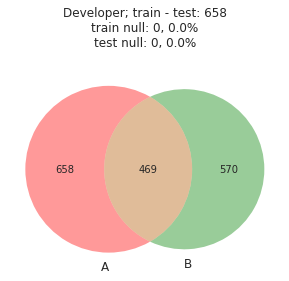

In [45]:
show_venn(df_train, df_test, 'Developer')
plt.tight_layout()

In [46]:
testtmp = df_test[df_test.loc[:, 'Publisher'] != 'Unknown']

In [47]:
df_test.shape, testtmp.shape

((8360, 13), (8159, 13))

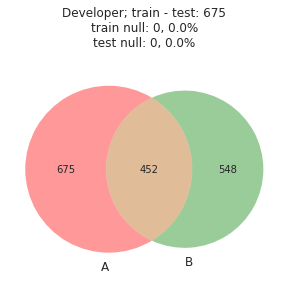

In [48]:
show_venn(df_train, testtmp, 'Developer')
plt.tight_layout()